[Chapter 8] Testing Set Overfitting

In [48]:
import numpy as np
import pandas as pd

from scipy.stats import norm, percentileofscore
import scipy.stats as ss

import matplotlib.pyplot as plt

false strategy theorem

In [ ]:
def getExpectedMaxSR(nTrials, meanSR, stdSR):
    """"
    compute expected max Sharpe Ratio, controlled for SBuMT(Selection Bias under Multiple Testing, which tends to inflate SR)
    based on false strategy theorem
    """
    
    emc = 0.577215664901532860606512090082402431042159336 # Euler-Mascheroni constant
    sr0 = (1-emc)*norm.ppf(1-1./nTrials) + emc*norm.ppf(1-(nTrials*np.e)**-1)
    sr0 = meanSR + stdSR*sr0

    return sr0

#-------------------------------------------------------------------------------------------

def getDistMaxSR(nSims, nTrials, stdSR, meanSR):
    """
    perform monte Carlo simulation to estimate the distribution of the maximum Sharpe Ratio (max{SR}) 
    on nTrials, from nSims simulations
    """
    rng = np.random.RandomState()
    out = pd.DataFrame()
    for nTrials_ in nTrials:

        # simulated sharpe ratios
        # nSims × nTrials_ matrix of random numbers from a standard normal distribution (mean=0, std=1)
        # each row is a simulation, each column a trial.
        sr = pd.DataFrame(rng.randn(nSims, nTrials_))
        # normalization (to make each row strictly follow standard normal distribution)
        # sr = sr - sr.mean
        sr = sr.sub(sr.mean(axis=1), axis=0) # center
        # sr = (sr - sr.mean) / sr.std
        sr = sr.div(sr.std(axis=1), axis=0) # scale
        # transform the normalized value to sharpe ratio sr ~ N(meanSR, stdSR^2)
        sr = meanSR + sr*stdSR

        # store output
        # find the maximum SR in each simulation (row) and store it in df 'max{SR}'
        out_ = sr.max(axis=1).to_frame('max{SR}')
        # also record the according number of trials used.
        out_['nTrials'] = nTrials_
        out = pd.concat([out, out_], ignore_index=True)

    return out

#---------------------------------------------------------------------------------------------

if __name__=='__main__':
    # generate 100 trial counts (nTrials) ranging from 10^1 to 10^2 on log scale
    # covert to int and set to remove duplicate
    # adjust logspace(1,6,1000) in book to logspace(1,2,100) due to hardware contraints
    nTrials = list(set(np.logspace(1,2,100).astype(int)))
    nTrials.sort()
    # compute the theoretical expected maximum SR for each nTrials
    sr0 = pd.Series({i:getExpectedMaxSR(i, meanSR=0, stdSR=1) for i in nTrials})
    # use Monte Carlo simulation (getDistMaxSR) to empirically estimate the distribution of the maximum SR for each nTrials
    sr1 = getDistMaxSR(nSims=100, nTrials=nTrials, meanSR=0, stdSR=1)  # adjust nSims from 1000 to 100 due to hardware contraints

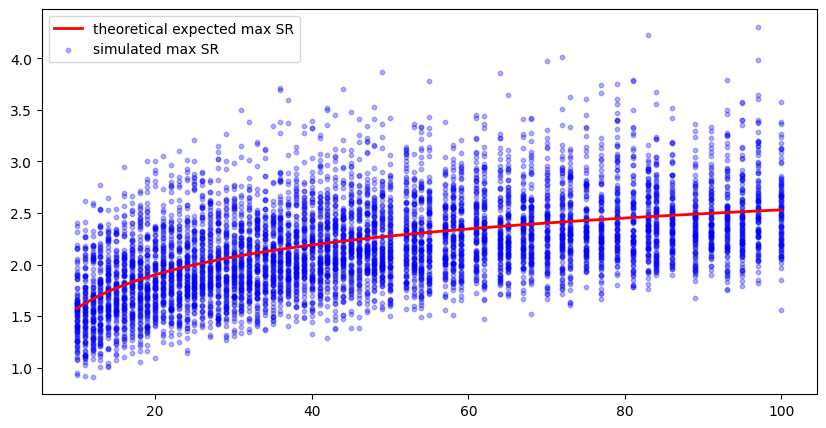

In [ ]:
# visualization

plt.figure(figsize=(10, 5))

# plot sr0 (theoretical line)
plt.plot(sr0.index, sr0.values, 
         color='red', 
         linewidth=2, 
         label='theoretical expected max SR')

# plot sr1 (simulated scatter)
plt.scatter(sr1['nTrials'], sr1['max{SR}'], 
            color='blue', 
            alpha=0.3,  # semi-transparent points
            s=10,       # point size
            label='simulated max SR')

plt.legend()

# while true SR ~ N(0, 1)

In [ ]:
def getMeanStdError(nSims0, nSims1, nTrials, stdSR=1, meanSR=0):
    """
    compute standard deviation of errors per nTrial 
    (approximation error as the difference between experimental prediction vs. thorem's prediction)
    - nTrials: number of SR used to derive max{SR}
    - nSims0: number of mc simulations used to estimate experimental max{SR} (simulations per error sample)
    - nSims1: number of experiments to repeat to compute std (number of error samples) 
    """
    # compute theorectical expected max sr based on theorem
    sr0 = pd.Series({i: getExpectedMaxSR(i, meanSR, stdSR) for i in nTrials})
    sr0 = sr0.to_frame('E[max{SR}]')
    sr0.index.name = 'nTrials'


    # compute monte carlo simulatd max sr
    err = pd.DataFrame()
    for i in range(int(nSims1)):
        sr1 = getDistMaxSR(nSims=nSims0, nTrials=nTrials, meanSR=0, stdSR=1) 
        sr1 = sr1.groupby('nTrials').mean()
        err_ = sr0.join(sr1).reset_index()
        err_['err'] = err_['max{SR}']/err_['E[max{SR}]'] - 1.
        err = pd.concat([err, err_])
    
    # stat
    # average relative error per nTrials
    out = {'meanErr': err.groupby('nTrials')['err'].mean()}
    # standard deviation of errors per nTrials
    out['stdErr'] = err.groupby('nTrials')['err'].std()
    out = pd.DataFrame.from_dict(out, orient='columns')

    return out

#------------------------------------------------------------------------------------------------------

if __name__=='__main__':
    # generate 100 trial counts (nTrials) ranging from 10^1 to 10^4 on log scale
    # covert to int and set to remove duplicate
    # adjust logspace(1,6,1000) in book to logspace(1,4,100) due to hardware contraints
    nTrials = list(set(np.logspace(1,4,100).astype(int)))
    nTrials.sort()
    # approximation error
    stats = getMeanStdError(nSims0=1000, nSims1=100, nTrials=nTrials, stdSR=1)

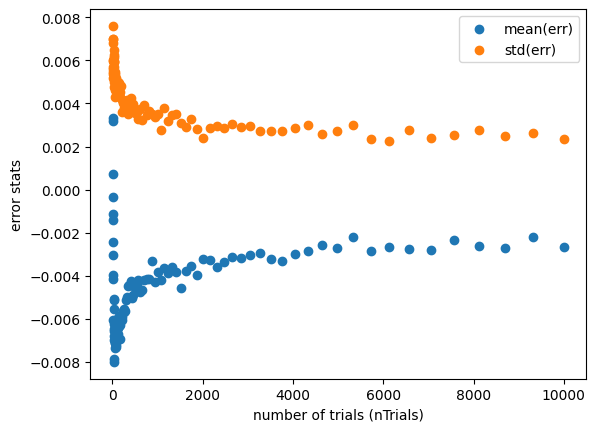

In [47]:
plt.scatter(stats.index, stats['meanErr'], label='mean(err)')
plt.scatter(stats.index, stats['stdErr'], label='std(err)')

plt.xlabel('number of trials (nTrials)', fontsize=10) 
plt.ylabel('error stats', fontsize=10)

plt.legend()

# std(err) is relatively small (below 0.5%) and it decreases as the number of trials increases
# mean(err) is negative, indicating smaller experimental max SR (than theorectial expected SR), and thus mostly false positive strategy

familywise error rate (FWER)

In [ ]:
# type I error, with numeric example

def getZStat(sr, t, sr_=0, skew=0, kurt=3):
    """"
    compute the z-stat to test whether sr is significantly greater than a threshold sr_
    Bailey and Lopez de Prado (2012)
    """
    z = (sr-sr_)*(t-1)**.5
    z /= (1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return z

#----------------------------------------------------------

def typeIErr(z, k=1):
    """
    compute false positive ratio
    """
    # alpha (false positive rate for a single trial) = P(reject H0|H0 is true) = P(Z>=z) = cdf(-z)  
    # (H0: SR=0 vs. H1: SR>0)
    alpha = ss.norm.cdf(-z)
    # the probability of making at least one type I error over K independent trials
    alpha_k = 1 - (1-alpha)**k  # correct for multiple testing
    return alpha, alpha_k

#----------------------------------------------------------

def main0():
    """
    numerical example
    """
    t, skew, kurt, k, freq = 1250, -3, 10, 10, 250
    # non-annualized sr
    sr = 0.0791
    # threshold
    sr_ = 0
    # z-stat 
    z = getZStat(sr, t, sr_, skew, kurt)
    z_norm = getZStat(sr, t, sr_, 0, 3) # if normal distribution
    alpha, alpha_k = typeIErr(z, k=k)
    alpha_norm, alpha_norm_k = typeIErr(z_norm, k=k)

    print(sr*freq**.5, alpha, alpha_k, alpha_norm, alpha_norm_k)
    
    return

#----------------------------------------------------------

if __name__=='__main__': main0()

# based on result, even though the annualied sr is approx. 1.25
#   the prob that this startegy is a false discovery is still relatively high (6.06%)
#   given 1) alpha_k reach 6.06% as the number of trials k=10 (while alpha = 0.62% if k=1)
#         2) non-normality of return (if normal distribution, alpha = 0.26% and alpha_k = 2.60%)


1.250680814596594 0.00622749669269935 0.06055845781327418 0.0026262512322785068 0.02595430221734163


In [ ]:
# type II error, with numeric example

